<a href="https://colab.research.google.com/github/rickiepark/llm-from-scratch/blob/main/ch05/01_main-chapter-code/ch05.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

<table style="width:100%">
<tr>
<td style="vertical-align:middle; text-align:left;">
<font size="2">
세바스찬 라시카(Sebastian Raschka)가 쓴 <a href="http://mng.bz/orYv">Build a Large Language Model From Scratch</a>의 번역서 <br><<b><a href="<a href="http://tensorflow.blog/llm-from-scratch">밑바닥부터 만들면서 배우는 LLM</a></b>>의 예제 코드입니다.<br>
<br>코드 저장소: <a href="https://github.com/rickiepark/llm-from-scratch">https://github.com/rickiepark/llm-from-scratch</a>
</font>
</td>
<td style="vertical-align:middle; text-align:left;">
<a href="http://tensorflow.blog/llm-from-scratch"><img src="https://tensorflowkorea.wordpress.com/wp-content/uploads/2025/09/ebb091ebb094eb8ba5llm_ebb3b8ecb185_ec959eeba9b4.jpg" width="100px"></a>
</td>
</tr>
</table>


# 5장: 레이블이 없는 데이터를 활용한 사전 훈련

In [33]:
from importlib.metadata import version

pkgs = ["matplotlib",
        "numpy",
        "tiktoken",
        "torch",
        "tensorflow" # OpenAI의 사전 훈련된 가중치를 위해서
       ]
for p in pkgs:
    print(f"{p} 버전: {version(p)}")

matplotlib 버전: 3.10.6
numpy 버전: 1.26.4
tiktoken 버전: 0.12.0
torch 버전: 2.5.1
tensorflow 버전: 2.19.1


- 이 장에서 LLM을 사전 훈련하기 위해 훈련 루프를 구현하고 기본적인 모델 평가 방법을 알아 보겠습니다.
- 이 장의 끝에서는 OpenAI의 사전 훈련된 가중치를 우리가 직접 구현한 모델에 로드해 보겠습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/01.webp" width=800px>

- 이 장에서 다루는 주제는 다음과 같습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/02.webp" width=800px>

## 5.1 텍스트 생성 모델 평가

- 이전 장에 코드를 사용하여 GPT 모델을 초기화하는 방법을 간략히 정리합니다.
- 그다음 LLM을 위한 기본적인 평가 지표를 소개합니다.
- 이 절의 마지막에서 이 평가 지표를 훈련 세트와 검증 세트에 적용합니다.

### 5.1.1 GPT를 사용해 텍스트 생성하기

- 이전 장의 코드를 사용하여 GPT 모델을 초기화합니다.

In [34]:
# 깃허브에서 previous_chapters.py 파일을 다운로드합니다.
!wget https://bit.ly/3HlFmc8 -O previous_chapters.py

zsh:1: command not found: wget


In [35]:
import torch
from gpt_module import GPTModel

GPT_CONFIG_124M = {
    "vocab_size": 50257,   # 어휘 사전 크기
    "context_length": 256, # 짧은 문맥 길이 (원본 길이: 1024)
    "emb_dim": 768,        # 임베딩 차원
    "n_heads": 12,         # 어텐션 헤드 개수
    "n_layers": 12,        # 층 개수
    "drop_rate": 0.1,      # 드롭아웃 비율
    "qkv_bias": False      # 쿼리-키-값 생성시 편향 사용 여부
}

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.eval();  # 추론 시에는 드롭아웃을 비활성화합니다

- 위에서 드롭아웃을 0.1로 지정했지만 요즘에는 드롭아웃을 사용하지 않고 LLM을 훈련하는 경우가 많습니다.
- 최신 LLM은 (초기 GPT 모델과 달리) 쿼리, 키, 값 행렬을 위한 `nn.Linear` 층에서 편향 벡터를 사용하지 않습니다. 그래서 `"qkv_bias": False`로 지정합니다.
- 모델 훈련에 필요한 계산 자원을 절감하기 위해 문맥 길이(`context_length`)를 256 토큰으로 줄입니다. 원본 1억 2,400만 파라미터의 GPT-2 모델은 1024개의 토큰을 사용했습니다.
  - 대부분의 독자들은 이 코드 예제를 랩탑 컴퓨터에서 실행하기 때문입니다.
  - 하지만 `context_length`를 1,024개 토큰으로 늘려서 실험해도 괜찮습니다(어떤 코드도 바꿀 필요가 없습니다)
  - 나중에 `context_length`가 1,024인 모델을 사전 훈련된 가중치에서 로드하겠습니다.

- 그 다음이 이전 장에서 만든 `generate_text_simple` 함수를 사용해 텍스트를 생성합니다.
- 또한 두 개 유틸리티 함수 `text_to_token_ids`와 `token_ids_to_text`를 정의합니다. 이 장에서 토큰과 텍스트 표현 사이를 전환하는데 사용하겠습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/03.webp" width=900px>

In [36]:
import tiktoken
from gpt_module import generate_text_simple

# 텍스트 -> 토큰 id로 변환
def text_to_token_ids(text, tokenizer):
    encoded = tokenizer.encode(text, allowed_special={'<|endoftext|>'})
    encoded_tensor = torch.tensor(encoded).unsqueeze(0) # 배치 차원을 추가합니다.
    return encoded_tensor

# 토큰 id -> 텍스트로 변환
def token_ids_to_text(token_ids, tokenizer):
    flat = token_ids.squeeze(0) # 배치 차원을 삭제합니다
    return tokenizer.decode(flat.tolist())

start_context = "Every effort moves you"
tokenizer = tiktoken.get_encoding("gpt2")

# gpt2모델 실행
token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids(start_context, tokenizer),
    max_new_tokens=10,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you rentingetic wasnم refres RexMeCHicular stren


- 위해서 볼 수 있듯이 모델이 아직 훈련되지 않았기 때문에 좋은 텍스트를 생성하지 못합니다.
- 훈련 과정에서 어떤 것이 좋은 텍스트인지 어떻게 정량적으로 측정할 수 있을까요?
- 다음 절에서 훈련 과정을 모니터링할 수 있도록 생성된 출력의 손실을 계산하는 지표를 소개합니다.
- LLM 미세 튜닝을 다루는 다음 장에서 모델의 품질을 측정하는 또 다른 방법을 소개하겠습니다.

### 5.1.2 텍스트 생성 손실 계산하기: 크로스 엔트로피와 혼잡도

- 두 개의 훈련 샘플(행)에 대한 토큰 ID를 담고 있는 `inputs` 텐서가 있다고 가정해보죠.
- `inputs`에 해당하는 `targets`은 모델이 생성 해야할 토큰 ID를 담고 있습니다.
- 2장에서 데이터 로더를 구현할 때 설명했듯이 `targets`은 `inputs`에서 한 토큰씩 앞으로 이동한 것입니다.

In [37]:
inputs = torch.tensor([[16833, 3626, 6100],   # ["every effort moves",
                       [40,    1107, 588]])   #  "I really like"]

targets = torch.tensor([[3626, 6100, 345  ],  # [" effort moves you",
                        [1107,  588, 11311]]) #  " really like chocolate"]

- `inputs`을 모델에 주입하면 각각 세 개의 토큰으로 구성된 두 개의 입력 샘플에 대한 로짓 벡터를 얻습니다.
- 각각의 토큰는 어휘 사전 크기에 해당하는 50,257차원의 벡터입니다.
- 소프트맥스 함수를 적용하여 로짓 텐서을 확률 점수를 담고 있는 동일 차원의 텐서로 바꿀 수 있습니다.

In [38]:
with torch.no_grad():
    logits = model(inputs)

probas = torch.softmax(logits, dim=-1) # 어휘 사전의 각 토큰에 대한 확률
print(probas.shape) # 크기: (batch_size, num_tokens, vocab_size)

torch.Size([2, 3, 50257])


- 매우 작은 어휘 사전을 사용하는 아래 그림에서 확률 점수를 텍스트로 바꾸는 방법을 보여 줍니다. 이 장의 끝에서 이에 대해 논의하겠습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/04.webp" width=900px>

- 이전 장에서 설명했듯이 `argmax` 함수를 적용하여 확률 점수를 토큰 ID 바꿀 수 있습니다.
- 앞의 소프트맥스 함수는 각 토큰에 대해서 50,257 차원의 벡터를 생성합니다. `argmax` 함수는 이 벡터에서 가장 높은 확률을 가진 위치를 반환합니다. 이것이 주어진 토큰에 대한 예측 토큰의 아이디입니다.

- 배치에는 각각 세 개 토큰으로 구성된 두 개의 입력 샘플이 있으므로 2x3 크기의 예측 토큰을 얻습니다.

In [39]:
token_ids = torch.argmax(probas, dim=-1, keepdim=True)
print("토큰 ID:\n", token_ids)

토큰 ID:
 tensor([[[16657],
         [  339],
         [42826]],

        [[49906],
         [29669],
         [41751]]])


- 이 토큰을 디코딩하면 모델이 예측해야 할 토큰, 즉 타겟 토큰과 매우 다른 것을 알 수 있습니다.

In [40]:
print(f"첫 번째 샘플의 타깃: {token_ids_to_text(targets[0], tokenizer)}")
print(f"첫 번째 샘플의 타깃: {token_ids_to_text(token_ids[0].flatten(), tokenizer)}")

첫 번째 샘플의 타깃:  effort moves you
첫 번째 샘플의 타깃:  Armed heNetflix


- 이는 모델이 아직 훈련되지 않았기 때문입니다.
- 모델을 훈련하려면 정답 예측(타깃)에서 얼만큼 떨어져 있는지 알아야 합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/06.webp" width=900px>

- 타겟 인덱스에 해당하는 토큰 확률은 다음과 같습니다.

In [41]:
text_idx = 0
target_probas_1 = probas[text_idx, [0, 1, 2], targets[text_idx]] # [2, 3, 50257]
print("텍스트 1:", target_probas_1)

text_idx = 1
target_probas_2 = probas[text_idx, [0, 1, 2], targets[text_idx]]
print("텍스트 2:", target_probas_2)

텍스트 1: tensor([7.4540e-05, 3.1061e-05, 1.1563e-05])
텍스트 2: tensor([1.0337e-05, 5.6776e-05, 4.7559e-06])


- 확률이 1에 가까워지도록 이 값들을 최대화하는 것이 목표입니다.
- 수학적 최적화에서는 확률 점수 자체를 최대화하는 것보다 확률 점수의 로그를 최대화하는 것이 쉽습니다.

In [42]:
# 토큰 확률의 로그를 계산합니다.
log_probas = torch.log(torch.cat((target_probas_1, target_probas_2)))
print(log_probas)

tensor([ -9.5042, -10.3796, -11.3677, -11.4798,  -9.7764, -12.2561])


- 그 다음 로그 확률의 평균을 계산합니다.

In [43]:
# 각 토큰에 대한 평균 확률을 계산합니다.
avg_log_probas = torch.mean(log_probas)
print(avg_log_probas)

tensor(-10.7940)


- 모델 가중치를 최적화하여 평균 로그 확률을 가능한 크게 만드는 것이 목표입니다.
- 로그 때문에 가장 큰 가능한 값은 0이며, 현재는 0에서 부터 멀리 떨어져 있습니다.

- 딥러닝 에서는 평균 로그 확률을 최대화하는 것 대신에 음의 평균 로그 확률을 최소화하는 것이 일반적입니다. 이 예제의 경우 -10.7722를 최대화하여 0에 가깝게 만드는 것 대신에 10.7722을 최소화하여 0에 가깝게 만듭니다.
- -10.7722의 음수 값, 즉 10.7722을 딥러닝에서는 크로스 엔트로피 손실이라고 부릅니다.

In [44]:
neg_avg_log_probas = avg_log_probas * -1
print(neg_avg_log_probas)

tensor(10.7940)


- 파이토치는 이전 단계를 수행하는 `cross_entropy` 함수를 제공합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/07.webp" width=600px>

1. `cross_entropy` 함수를 적용하기 전에 로짓과 타깃의 크기를 확인해야 합니다.
2.  파이토치의 `cross_entropy` 함수를 위해 배치 차원을 기준으로 합쳐서 텐서를 펼쳐야 합니다.
3.  타깃은 토큰 ID이며, 최대화해야 할 로짓 텐서의 인덱스를 나타냅니다.
    - 파이토치의 `cross_entropy` 함수는 최대화할 토큰 인덱스에 대해 자동으로 소프트맥스와 로그 확률 계산을 수행합니다.

4. 크로스 엔트로피 손실에 관련된 개념은 LLM의 혼잡도입니다.
    - 혼잡도는 크로스 엔트로피 손실에 지수 함수를 적용한 것입니다.

In [45]:
## 1. 
# 로짓의 크기는 (batch_size, num_tokens, vocab_size)입니다.
print("로짓 크기:", logits.shape)

# 타깃의 크기는 (batch_size, num_tokens)입니다.
print("타깃 크기:", targets.shape)


## 2. 
logits_flat = logits.flatten(0, 1)
targets_flat = targets.flatten()

print("펼친 로짓:", logits_flat.shape)
print("펼친 타깃:", targets_flat.shape)

## 3. 
loss = torch.nn.functional.cross_entropy(logits_flat, targets_flat)
print(loss)

## 4. 
perplexity = torch.exp(loss)
print(perplexity)

로짓 크기: torch.Size([2, 3, 50257])
타깃 크기: torch.Size([2, 3])
펼친 로짓: torch.Size([6, 50257])
펼친 타깃: torch.Size([6])
tensor(10.7940)
tensor(48725.8203)


- 혼잡도는 모델이 각 단계에서 불확실해하는 실제 어휘사전 크기를 나타내기 때문에 원시 손실 값보다 이해하기 더 쉽습니다(이 예에서는 48,725개 단어 또는 토큰).
- 다른 말로 하면, 혼잡도는 모델이 예측한 확률 분포가 데이터셋에 있는 단어의 실제 분포와 얼마나 잘 맞는지를 측정합니다.
- 손실과 비슷하게 낮은 혼잡도는 모델 예측이 실제 분포에 가깝다는 것을 나타냅니다.

### 5.1.3 훈련 세트와 검증 세트의 손실 계산하기

- LLM 훈련을 위해 비교적 작은 데이터셋을 사용합니다(사실 단편 소설 하나를 사용합니다).
- 이유는 다음과 같습니다.
  - 적절한 GPU가 없는 랩탑 컴퓨터에서 몇 분 안에 코드 예제가 실행되어야 합니다.
  - 교육 목적을 위해 훈련이 비교적 빨리 끝나야 합니다(몇 주가 아니라 몇 분 만에).
  - 사용 권리를 위반하지 않으며 깃허브 저장소에 저장할 수 있는 크기의 공개된 텍스트를 사용해야 합니다.
- 예를 들어, Llama 2 7B는 2조 개의 토큰에서 훈련하기 위해 A100 GPU에서 184,320 GPU 시간이 필요합니다.
  - 이 글을 쓰는 시점에, AWS의 8xA100 클라우드 서버의 시간당 가격은 약 \$30입니다.
  - 따라서 대략 계산하면 이 LLM을 훈련하는데 184,320 / 8 * \$30 =  \$690,000이 듭니다.
- 아래에서는 2장에서 다루었던 데이터셋을 사용합니다.

In [46]:
import os
import requests

file_path = "the-verdict.txt"
url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

if not os.path.exists(file_path):
    response = requests.get(url, timeout=30)
    response.raise_for_status()
    text_data = response.text
    with open(file_path, "w", encoding="utf-8") as file:
        file.write(text_data)
else:
    with open(file_path, "r", encoding="utf-8") as file:
        text_data = file.read()

# 책에서는 다음 코드를 사용했지만 VPN을 사용하는 경우 urllib가 문제를 일으킬 수 있습니다.
# 따라서 더 안정적인 `requests` 패키지를 사용합니다.

# import os
# import urllib.request

# file_path = "the-verdict.txt"
# url = "https://raw.githubusercontent.com/rasbt/LLMs-from-scratch/main/ch02/01_main-chapter-code/the-verdict.txt"

# if not os.path.exists(file_path):
#     with urllib.request.urlopen(url) as response:
#         text_data = response.read().decode('utf-8')
#     with open(file_path, "w", encoding="utf-8") as file:
#         file.write(text_data)
# else:
#     with open(file_path, "r", encoding="utf-8") as file:
#         text_data = file.read()

- 다운로드한 텍스트를 확인하기 위해 처음과 끝에서 100 개의 문자를 출력하여 보죠.

In [47]:
# 처음 99개 문자
print(text_data[:99])

I HAD always thought Jack Gisburn rather a cheap genius--though a good fellow enough--so it was no 


In [48]:
# 마지막 99개 문자
print(text_data[-99:])

it for me! The Strouds stand alone, and happen once--but there's no exterminating our kind of art."


In [49]:
total_characters = len(text_data)
total_tokens = len(tokenizer.encode(text_data))

print("문자:", total_characters)
print("토큰:", total_tokens)

문자: 20479
토큰: 5145


이 텍스트의 토큰이 5,145개 뿐이라 LLM을 훈련하기에 너무 적어 보일 수 있습니다. 하지만 이는 교육적인 목적을 위해서입니다(나중에 사전 훈련된 가중치를 로드하겠습니다).

- 그 다음 데이터셋을 훈련 세트와 검증 세트로 나누고 2장의 데이터 로더를 사용해 LLM 훈련을 위한 배치를 준비합니다.
- 시각화때문에 아래 그림은 `max_length=6`라고 가정하지만, 훈련 데이터 로더에서 `max_length`는 LLM이 지원하는 문맥 길이와 같습니다.
- 아래 그림은 간단하게 나타내려고 입력 토큰만 보여줍니다.
  - LLM을 텍스트에 있는 다음 단어를 예측하도록 훈련하기 때문에 타깃은 한 토큰씩 이동한 것외에는 입력과 같습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/09.webp" width=900px>

In [50]:
from gpt_module import create_dataloader_v1

# 훈련 세트 비율
train_ratio = 0.90
split_idx = int(train_ratio * len(text_data))
train_data = text_data[:split_idx]
val_data = text_data[split_idx:]


torch.manual_seed(123)

train_loader = create_dataloader_v1(
    train_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=True,
    shuffle=True,
    num_workers=0
)

val_loader = create_dataloader_v1(
    val_data,
    batch_size=2,
    max_length=GPT_CONFIG_124M["context_length"],
    stride=GPT_CONFIG_124M["context_length"],
    drop_last=False,
    shuffle=False,
    num_workers=0
)

In [51]:
# 유효성 검사
if total_tokens * (train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("훈련 데이터 로더에 토큰이 충분하지 않습니다. "
          "`GPT_CONFIG_124M['context_length']`를 낮추거나 "
          "`training_ratio`를 증가시키세요.")

if total_tokens * (1-train_ratio) < GPT_CONFIG_124M["context_length"]:
    print("훈련 데이터 로더에 토큰이 충분하지 않습니다. "
          "`GPT_CONFIG_124M['context_length']`를 낮추거나 "
          "`training_ratio`를 증가시키세요.")

- 컴퓨팅 자원을 절감하고 데이터셋이 매우 작기 때문에 비교적 작은 배치 크기를 사용합니다.
- 예를 들어 Llama 2 7B는 배치 크기 1024에서 훈련되었습니다.

- 데이터가 올바르게 로드되었는지 확인합니다.

In [52]:
print("훈련 데이터 로더:")
for x, y in train_loader:
    print(x.shape, y.shape)

print("\n검증 데이터 로더:")
for x, y in val_loader:
    print(x.shape, y.shape)

훈련 데이터 로더:
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])
torch.Size([2, 256]) torch.Size([2, 256])

검증 데이터 로더:
torch.Size([2, 256]) torch.Size([2, 256])


- 토큰 크기가 예상 범위 안에 있는지 추가로 확인합니다.

In [53]:
train_tokens = 0
for input_batch, target_batch in train_loader:
    train_tokens += input_batch.numel()

val_tokens = 0
for input_batch, target_batch in val_loader:
    val_tokens += input_batch.numel()

print("훈련 토큰 수:", train_tokens)
print("검증 토큰 수:", val_tokens)
print("모든 토큰 수:", train_tokens + val_tokens)

훈련 토큰 수: 4608
검증 토큰 수: 512
모든 토큰 수: 5120


- 주어진 배치에서 크로스 엔트로피 손실을 계산 하는 유틸리티 함수를 작성 합니다
- 또한 데이터 로더에서 사용자가 지정한 배치 개수 만큼 추출하여 손실을 계산하는 두 번째 유틸리티 함수를 구현합니다.

In [ ]:
# 배치 한개씩 손실을 계산하는 함수
def calc_loss_batch(input_batch, target_batch, model, device):
    input_batch, target_batch = input_batch.to(device), target_batch.to(device)
    logits = model(input_batch)
    loss = torch.nn.functional.cross_entropy(logits.flatten(0, 1), target_batch.flatten())
    return loss


# 여러개의 배치의 손실을 합쳐서 계산하는 함수
def calc_loss_loader(data_loader, model, device, num_batches=None):
    total_loss = 0.
    if len(data_loader) == 0:
        return float("nan")
    elif num_batches is None:
        num_batches = len(data_loader)
    else:
        # num_batches가 데이터 로더에 있는 배치 개수보다 크면
        # 배치 횟수를 데이터 로더에 있는 총 배치 개수로 맞춥니다.
        num_batches = min(num_batches, len(data_loader))
    for i, (input_batch, target_batch) in enumerate(data_loader):
        if i < num_batches:
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            total_loss += loss.item()
        else:
            break
    return total_loss / num_batches

- CUDA를 지원하는 GPU를 가지고 있다면 어떤 코드도 변경할 필요 없이 GPU 에서 LLM을 훈련할 수 있습니다.
- `device` 설정을 통해 데이터를 LLM 모델과 동일한 장치에 로드합니다.

In [60]:
device = torch.device("cuda" if torch.cuda.is_available() else "mps")

# 노트:
# 애플 실리콘 칩에서 코드를 실행하는 경우 다음 주석을 해제하세요.
# (M3 맥북 에어에서 측정하면) 애플 CPU보다 약 2배 빠릅니다. 하지만 손실 값은 조금 다를 수 있습니다.

#if torch.cuda.is_available():
#    device = torch.device("cuda")
#elif torch.backends.mps.is_available():
#    device = torch.device("mps")
#else:
#    device = torch.device("cpu")
#
# print(f"Using {device} device.")


model.to(device) # nn.Module 클래스의 경우 model = model.to(device)로 할당할 필요가 없습니다.

torch.manual_seed(123) # 데이터 로더에서 셔플링이 일어나므로 재현가능성을 위해 설정합니다.

with torch.no_grad(): # 모델을 아직 훈련하지 않으므로 효율성을 위해 그레이디언트 추적을 끕니다.
    train_loss = calc_loss_loader(train_loader, model, device)
    val_loss = calc_loss_loader(val_loader, model, device)

print("훈련 손실:", train_loss)
print("검증 손실:", val_loss)

훈련 손실: 5.179231325785319
검증 손실: 6.347812652587891


<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/10.webp" width=800px>

## 5.2 LLM 훈련하기

- 이 절에서는 LLM 훈련을 위한 코드를 구현합니다.
- 여기서는 간단한 훈련 함수를 만듭니다(이 훈련 함수를 학습률 워밍업, 코사인 어닐링, 그레이디언트 클리핑 같은 고급 기법으로 확장하고 싶다면 [부록 D](../../appendix-D/01_main-chapter-code)를 참고하세요).

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/11.webp" width=600px>

In [61]:
def train_model_simple(model, train_loader, val_loader, optimizer, device, num_epochs,
                       eval_freq, eval_iter, start_context, tokenizer):
    # 손실과 지금까지 처리한 토큰 수를 추적하기 위해 리스트를 초기화합니다.
    train_losses, val_losses, track_tokens_seen = [], [], []
    tokens_seen, global_step = 0, -1

    # 메인 훈련 루프를 시작합니다.
    for epoch in range(num_epochs):
        model.train()  # 모델을 훈련 모드로 설정합니다.

        for input_batch, target_batch in train_loader:
            optimizer.zero_grad() # 이전 배치 반복에서 얻은 손실의 그레이디언트를 초기화합니다.
            loss = calc_loss_batch(input_batch, target_batch, model, device)
            loss.backward() # 손실의 그레이디언트를 계산합니다.
            optimizer.step() # 손실의 그레이디언트를 사용하여 모델 가중치를 업데이트합니다.
            tokens_seen += input_batch.numel()
            global_step += 1

            # 추가적인 평가 단계
            if global_step % eval_freq == 0:
                train_loss, val_loss = evaluate_model(
                    model, train_loader, val_loader, device, eval_iter)
                train_losses.append(train_loss)
                val_losses.append(val_loss)
                track_tokens_seen.append(tokens_seen)
                print(f"에포크 {epoch+1} (Step {global_step:06d}): "
                      f"훈련 손실 {train_loss:.3f}, 검증 손실 {val_loss:.3f}")

        # 각 에포크 후에 샘플 텍스트를 출력합니다.
        generate_and_print_sample(
            model, tokenizer, device, start_context
        )

    return train_losses, val_losses, track_tokens_seen


def evaluate_model(model, train_loader, val_loader, device, eval_iter):
    model.eval()
    with torch.no_grad():
        train_loss = calc_loss_loader(train_loader, model, device, num_batches=eval_iter)
        val_loss = calc_loss_loader(val_loader, model, device, num_batches=eval_iter)
    model.train()
    return train_loss, val_loss


def generate_and_print_sample(model, tokenizer, device, start_context):
    model.eval()
    context_size = model.pos_emb.weight.shape[0]
    encoded = text_to_token_ids(start_context, tokenizer).to(device)
    with torch.no_grad():
        token_ids = generate_text_simple(
            model=model, idx=encoded,
            max_new_tokens=50, context_size=context_size
        )
    decoded_text = token_ids_to_text(token_ids, tokenizer)
    print(decoded_text.replace("\n", " "))  # 간결한 출력 포맷을 위해
    model.train()

- 위에 정의한 훈련 함수로 LLM을 훈련해 보죠.

In [62]:
# 노트:
# 실행 시간을 계산하고 싶다면 다음 주석을 해제하세요.
# import time
# start_time = time.time()

torch.manual_seed(123)
model = GPTModel(GPT_CONFIG_124M)
model.to(device)
optimizer = torch.optim.AdamW(model.parameters(), lr=0.0004, weight_decay=0.1)

num_epochs = 10
train_losses, val_losses, tokens_seen = train_model_simple(
    model, train_loader, val_loader, optimizer, device,
    num_epochs=num_epochs, eval_freq=5, eval_iter=5,
    start_context="Every effort moves you", tokenizer=tokenizer
)

# Note:
# 실행 시간을 계산하고 싶다면 다음 주석을 해제하세요.
# end_time = time.time()
# execution_time_minutes = (end_time - start_time) / 60
# print(f"훈련 소요 시간: {execution_time_minutes:.2f}분.")

에포크 1 (Step 000000): 훈련 손실 10.973, 검증 손실 10.985
에포크 1 (Step 000005): 훈련 손실 9.639, 검증 손실 9.768
Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
에포크 2 (Step 000010): 훈련 손실 8.412, 검증 손실 8.663
에포크 2 (Step 000015): 훈련 손실 7.348, 검증 손실 7.656
Every effort moves you the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the the
에포크 3 (Step 000020): 훈련 손실 6.500, 검증 손실 6.898
에포크 3 (Step 000025): 훈련 손실 6.101, 검증 손실 6.639
Every effort moves you the... the the. the the the.. the.. the the the the the. the the.. the. the. the the. the the the the. the. the. the the. the the. the. the
에포크 4 (Step 000030): 훈련 손실 6.015, 검증 손실 6.624
에포크 4 (Step 000035): 훈련 손실 6.012, 검증 손실 6.676
Every effort moves yo

- 여러분의 결과와 손실 값이 조금 다를 수 있습니다. 대체적으로 비슷하다면 (훈련 손실은 1이하이고 검증 손실은 7이하이면) 걱정할 필요가 없습니다.
- GPU 하드웨어와 CUDA 버전 또는 파이토치의 신버전에서 바뀐 변화 때문에 차이가 발생할 수 있습니다.
- CPU에서 이 예제를 실행하더라도 작은 차이를 볼 수 있습니다. 이런 차이를 만드는 원인 중 하나는 파이토치가 컴파일된 운영체제에 따라 `nn.Dropout`의 동작 방식이 다르기 때문입니다. 자세한 내용은 파이토치 [깃허브 이슈](https://github.com/pytorch/pytorch/issues/121595)를 참고하세요.

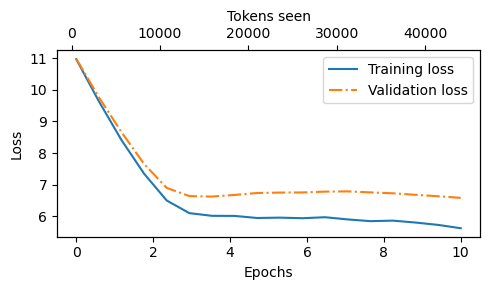

In [63]:
import matplotlib.pyplot as plt
from matplotlib.ticker import MaxNLocator


def plot_losses(epochs_seen, tokens_seen, train_losses, val_losses):
    fig, ax1 = plt.subplots(figsize=(5, 3))

    # 에포크에 대한 훈련 손실과 검증 손실의 그래프를 그립니다.
    ax1.plot(epochs_seen, train_losses, label="Training loss")
    ax1.plot(epochs_seen, val_losses, linestyle="-.", label="Validation loss")
    ax1.set_xlabel("Epochs")
    ax1.set_ylabel("Loss")
    ax1.legend(loc="upper right")
    ax1.xaxis.set_major_locator(MaxNLocator(integer=True))  # only show integer labels on x-axis

    # 처리한 토큰 수에 대한 두 번째 x 축을 만듭니다.
    ax2 = ax1.twiny()  # y 축을 공유하는 두 번째 x 축을 만듭니다.
    ax2.plot(tokens_seen, train_losses, alpha=0)  # 눈금을 정렬하기 위해 투명한 그래프를 만듭니다.
    ax2.set_xlabel("Tokens seen")

    fig.tight_layout()
    plt.savefig("loss-plot.pdf")
    plt.show()

epochs_tensor = torch.linspace(0, num_epochs, len(train_losses))
plot_losses(epochs_tensor, tokens_seen, train_losses, val_losses)

- 위 결과를 보면 모델이 처음에는 이해할 수 없는 단어를 생성하지만 마지막으로 갈수록 문법적으로 어느 정도 정확한 문장을 생성합니다.
- 하지만 훈련 세트 손실과 검증 세트 손실을 보면 모델이 과대적합되기 시작합니다.
- 마지막 부분의 몇 문장을 확인하면 훈련 세트에 있는 내용이라는 것을 알 수 있습니다. 모델이 단순히 훈련 데이터를 암기한 것입니다.
- 매우 작은 훈련 세트를 사용하고 모델을 여러 에포크에서 훈련하고 있기 때문에 과대적합이 일어납니다.
  - 여기서는 교육적인 목적을 위해 LLM을 훈련합니다. 모델이 일관된 텍스트를 생성하는 방법을 학습할 수 있는지 확인하는 것이 주요 목적입니다.
  - 대량의 고가 하드웨어에서 몇 주 또는 몇 달 동안 이런 모델을 훈련하는 대신에 나중에 사전 훈련된 가중치를 로드하여 사용하겠습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/13.webp" width=800px>

- 더 큰 훈련 데이터셋에서 오래 모델을 훈련하고 싶다면 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)을 참고하세요

## 5.3 무작위성을 제어하기 위한 디코딩 전략

- 위에서 구현한 GPT 모델처럼 작은 LLM의 추론 비용은 비교적 저렴합니다. 따라서 훈련에 GPU를 사용했더라도 추론에서는 GPU를 사용할 필요가 없습니다.
- 이전 장에서 만든 `generate_text_simple` 함수를 사용해 한 번에 하나의 단어(또는 토큰)씩 새로운 텍스트를 생성할 수 있습니다.
- 5.1.2절에서 설명했듯이 생성된 다음 토큰은 어휘사전의 모든 토큰 중에서 확률 점수가 가장 높은 토큰입니다.

In [65]:
# NEW: 이후 코드의 결과를 책과 일치하도록 만들기 위해 CPU를 사용합니다.
inference_device = torch.device("cpu")

model.to(inference_device)
model.eval()

tokenizer = tiktoken.get_encoding("gpt2")

token_ids = generate_text_simple(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=25,
    context_size=GPT_CONFIG_124M["context_length"]
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you,,,,,,,,,,,,,,,,,,, the,,,,,


- `generate_text_simple` 함수를 여러번 실행하더라도 LLM은 항상 동일한 출력을 생성합니다.
- `generate_text_simple`를 수정하기 위해 두 가지 디코딩 전략을 소개합니다. *온도 스케일링*과 *탑-k* 샘플링입니다.
- 이를 사용해 모델이 생성된 텍스트의 무작위성과 다양성을 조절할 수 있습니다.

### 5.3.1 온도 스케일링

- 이전에는 `torch.argmax`를 사용해 항상 가장 높은 확률을 가진 토큰을 다음 토큰으로 샘플링했습니다.
- 다양성을 추가하기 위해 확률 분포에서 샘플링하도록 `torch.multinomial(probs, num_samples=1)`을 사용해 토큰을 샘플링할 수 있습니다.
- 여기서 각 인덱스 선택 가능성은 입력 텐서에 있는 확률에 따라 결정됩니다.

- 여기에서 다음 토큰 생성에 대해 간략히 정리해 보겠습니다. 설명을 위해 매우 작은 어휘사전을 사용합니다.

In [68]:
vocab = {
    "closer": 0,
    "every": 1,
    "effort": 2,
    "forward": 3,
    "inches": 4,
    "moves": 5,
    "pizza": 6,
    "toward": 7,
    "you": 8,
}

inverse_vocab = {v: k for k, v in vocab.items()}

# 입력이 "every effort moves you"이고
# LLM이 다음 토큰을 위해 아래와 같은 로짓을 반환했다고 가정해 보죠.
next_token_logits = torch.tensor(
    [4.51, 0.89, -1.90, 6.75, 1.63, -1.62, -1.89, 6.28, 1.79]
)

probas = torch.softmax(next_token_logits, dim=0)
next_token_id = torch.argmax(probas).item()

# 생성될 토큰은 다음과 같습니다.
print(inverse_vocab[next_token_id])

forward


In [73]:
torch.manual_seed(123)
next_token_id = torch.multinomial(probas, num_samples=1).item()
print(inverse_vocab[next_token_id])

forward


- `torch.argmax`로 가장 가능성이 높은 토큰을 결정하는 대신에 `torch.multinomial(probas, num_samples=1)`를 사용해 소프트맥스 분포에서 샘플링하여 가장 가능성이 높은 토큰을 결정할 수 있습니다.
- 설명을 위해 원래 소프트맥스 분포에서 1,000번 토큰을 샘플링해 보죠.

In [71]:
def print_sampled_tokens(probas):
    torch.manual_seed(123) # 재현가능성을 위한 랜덤 시드
    sample = [torch.multinomial(probas, num_samples=1).item() for i in range(1_000)]
    sampled_ids = torch.bincount(torch.tensor(sample), minlength=len(probas))
    for i, freq in enumerate(sampled_ids):
        print(f"{freq} x {inverse_vocab[i]}")

print_sampled_tokens(probas)

73 x closer
0 x every
0 x effort
582 x forward
2 x inches
0 x moves
0 x pizza
343 x toward
0 x you


- 온도 스케일링으로 분포와 선택 과정을 조절할 수 있습니다.
- "온도 스케일링"은 로짓을 0보다 큰 숫자로 나누는 것을 의미합니다.
- 1보다 큰 온도는 소프트맥스 함수를 적용한 후에 더 균등한 토큰 확률 분포를 만듭니다.
- 1보다 작은 온도는 소프트맥스 함수를 적용한 후에 더 결정론적인 분포(더 날카롭거나 뾰족한 분포)를 만듭니다.

In [74]:
def softmax_with_temperature(logits, temperature):
    scaled_logits = logits / temperature
    return torch.softmax(scaled_logits, dim=0)

# 온도 값
temperatures = [1, 0.1, 5]  # 원본, 낮은 온도, 높은 온도

# 스케일을 조정한 확률 계산
scaled_probas = [softmax_with_temperature(next_token_logits, T) for T in temperatures]

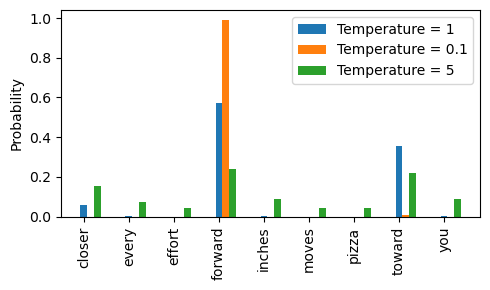

In [75]:
# 그래프 그리기
x = torch.arange(len(vocab))
bar_width = 0.15

fig, ax = plt.subplots(figsize=(5, 3))
for i, T in enumerate(temperatures):
    rects = ax.bar(x + i * bar_width, scaled_probas[i], bar_width, label=f'Temperature = {T}')

ax.set_ylabel('Probability')
ax.set_xticks(x)
ax.set_xticklabels(vocab.keys(), rotation=90)
ax.legend()

plt.tight_layout()
plt.savefig("temperature-plot.pdf")
plt.show()

- 온도 0.1로 스케일을 조정하면 더 뾰족한 분포를 만들어, `torch.argmax`에 가까워져 항상 가장 가능성있는 토큰이 선택됩니다.

In [76]:
print_sampled_tokens(scaled_probas[1])

0 x closer
0 x every
0 x effort
985 x forward
0 x inches
0 x moves
0 x pizza
15 x toward
0 x you


- 온도 5로 스케일을 조정한 확률은 더 균등한 분포가 됩니다.

In [77]:
print_sampled_tokens(scaled_probas[2])

165 x closer
75 x every
42 x effort
239 x forward
71 x inches
46 x moves
32 x pizza
227 x toward
103 x you


- LLM 입력이 "every effort moves you"일 경우 위와 같은 방법을 사용하면 "every effort moves you pizza"와 같이 3.2%의 확률(1,000번 중에 32번)로 이따금 말이 안되는 텍스트를 생성합니다.

### 5.3.2 탑-k 샘플링

- 높은 온도를 사용하여 출력의 다양성을 증가시키면서 말이 안되는 문장이 생성될 가능성을 낮추기 위해 가장 가능성있는 상위 k개 토큰으로 샘플링될 토큰을 제한할 수 있습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/15.webp" width=700px>

- (이 그림의 숫자는 간단하게 나타내려고 소숫점 두자리 이후를 자른 값입니다. 소프트맥스 열의 값은 모두 더해서 1.0이 되어야 합니다)

- 코드로는 다음과 같이 구현할 수 있습니다.

In [78]:
top_k = 3
top_logits, top_pos = torch.topk(next_token_logits, top_k)

print("탑-k 로짓:", top_logits)
print("탑-k 위치:", top_pos)

탑-k 로짓: tensor([6.7500, 6.2800, 4.5100])
탑-k 위치: tensor([3, 7, 0])


In [79]:
new_logits = torch.where(
    condition=next_token_logits < top_logits[-1],
    input=torch.tensor(float("-inf")),
    other=next_token_logits
)

print(new_logits)

tensor([4.5100,   -inf,   -inf, 6.7500,   -inf,   -inf,   -inf, 6.2800,   -inf])


> 노트:  
>
>  이전 코드를 조금 더 효율적으로 구현하는 방법은 다음과 같습니다.
>
> ```python
> new_logits = torch.full_like( # -inf 값을 담은 텐서를 만듭니다.
>    next_token_logits, -torch.inf
>)   
> new_logits[top_pos] = next_token_logits[top_pos] # -inf 텐서에 상위 k개 값을 복사합니다.
> ```
> <br>
> 자세한 내용은 다음을 참고하세요: https://github.com/rasbt/LLMs-from-scratch/discussions/326


In [80]:
topk_probas = torch.softmax(new_logits, dim=0)
print(topk_probas)

tensor([0.0615, 0.0000, 0.0000, 0.5775, 0.0000, 0.0000, 0.0000, 0.3610, 0.0000])


### 5.3.3 텍스트 생성 함수 수정하기

- 이전 두 개의 절에서 온도 스케일링과 탑-k 샘플링을 소개했습니다.
- 두 개념을 사용해 앞서 LLM으로 텍스트를 생성할 때 사용한 `generate_sample` 함수를 수정해 새로운 `generate` 함수를 만들어 보죠.

In [81]:
def generate(model, idx, max_new_tokens, context_size, temperature=0.0, top_k=None, eos_id=None):

    # for 루프는 이전과 동일합니다. 로짓을 받아 마지막 타임 스텝만 사용합니다.
    for _ in range(max_new_tokens):
        idx_cond = idx[:, -context_size:]
        with torch.no_grad():
            logits = model(idx_cond)
        logits = logits[:, -1, :]

        # 탑-k 샘플링으로 로짓을 필터링합니다.
        if top_k is not None:
            # 탑-k 값만 유지합니다.
            top_logits, _ = torch.topk(logits, top_k)
            min_val = top_logits[:, -1]
            logits = torch.where(logits < min_val, torch.tensor(float("-inf")).to(logits.device), logits)

        # 온도 스케일링을 적용합니다.
        if temperature > 0.0:
            logits = logits / temperature

            # (책에 없음): mps 장치에서 동일한 결과를 얻기 위해 수치 안정성을 위한 팁
            # 소프트맥스 전에 행의 최댓값을 뺍니다.
            logits = logits - logits.max(dim=-1, keepdim=True).values

            # 소프트맥스 함수를 적용하여 확률을 얻습니다.
            probs = torch.softmax(logits, dim=-1)  # (batch_size, context_len)

            # 분포에서 샘플링합니다.
            idx_next = torch.multinomial(probs, num_samples=1)  # (batch_size, 1)

        # 온도 스케일링을 사용하지 않는 경우 이전처럼 그리디 샘플링을 사용해 다음 토큰을 선택합니다.
        else:
            idx_next = torch.argmax(logits, dim=-1, keepdim=True)  # (batch_size, 1)

        if idx_next == eos_id:  # eos_id가 지정되어 있고 EoS 토큰을 만나면 생성을 중단합니다.
            break

        # 이전과 동일하게 샘플링된 인덱스를 현재 시퀀스 뒤에 추가합니다.
        idx = torch.cat((idx, idx_next), dim=1)  # (batch_size, num_tokens+1)

    return idx

In [82]:
torch.manual_seed(123)

token_ids = generate(
    model=model,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(inference_device),
    max_new_tokens=15,
    context_size=GPT_CONFIG_124M["context_length"],
    top_k=25,
    temperature=1.4
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you, I." I it a,. his that " my a " had


## 5.4 파이토치로 모델 로드하고 저장하기

- LLM 훈련에는 계산 비용이 많이 듭니다. 따라서 LLM 가중치를 저장하고 로드하는 것이 중요합니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/16.webp" width=800px>

- 파이토치에서는 `torch.save` 함수를 `.state_dict()` 메서드 결과에 적용해 소위 `state_dict`인 모델 가중치를 저장하는 것이 권장됩니다.

In [83]:
torch.save(model.state_dict(), "model.pth")

- 그다음 모델 가중치를 새로운 `GPTModel` 클래스 인스턴스에 로드할 수 있습니다.

In [84]:
model = GPTModel(GPT_CONFIG_124M)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("model.pth", map_location=device, weights_only=True))
model.eval()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

- 일반적인 SGD 대신 Adam이나 AdamW와 같이 적응형 옵티마이저로 LLM을 훈련하는 것이 일반적입니다.
- 이런 적응형 옵티마이저는 모델 가중치마다 추가적인 파라미터를 저장합니다. 나중에 사전 훈련을 계속하려면 이 파라미터도 저장하는 것이 맞습니다.

In [85]:
torch.save({
    "model_state_dict": model.state_dict(),
    "optimizer_state_dict": optimizer.state_dict(),
    },
    "model_and_optimizer.pth"
)

In [86]:
checkpoint = torch.load("model_and_optimizer.pth", weights_only=True)

model = GPTModel(GPT_CONFIG_124M)
model.load_state_dict(checkpoint["model_state_dict"])

optimizer = torch.optim.AdamW(model.parameters(), lr=0.0005, weight_decay=0.1)
optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
model.train()

GPTModel(
  (tok_emb): Embedding(50257, 768)
  (pos_emb): Embedding(256, 768)
  (drop_emb): Dropout(p=0.1, inplace=False)
  (trf_blocks): Sequential(
    (0): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features=768, out_features=768, bias=False)
        (W_key): Linear(in_features=768, out_features=768, bias=False)
        (W_value): Linear(in_features=768, out_features=768, bias=False)
        (out_proj): Linear(in_features=768, out_features=768, bias=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (ff): FeedForward(
        (layers): Sequential(
          (0): Linear(in_features=768, out_features=3072, bias=True)
          (1): GELU()
          (2): Linear(in_features=3072, out_features=768, bias=True)
        )
      )
      (norm1): LayerNorm()
      (norm2): LayerNorm()
      (drop_shortcut): Dropout(p=0.1, inplace=False)
    )
    (1): TransformerBlock(
      (att): MultiHeadAttention(
        (W_query): Linear(in_features

## 5.5 오픈AI에서 사전 훈련된 가중치 로드하기

- 앞서 하나의 단편 소설로 구성된 작은 데이터셋을 사용해 소규모 GPT-2 모델을 훈련했습니다.
- 구텐베르크 프로젝트에 있는 전체 책으로 더 오래 모델을 훈련하고 싶다면 [../03_bonus_pretraining_on_gutenberg](../03_bonus_pretraining_on_gutenberg)을 참고하세요.
- 다행히 오픈AI는 GPT-2 모델의 가중치를 공개적으로 제공하기 때문에 대규모 말뭉치에서 모델을 재훈련하기 위해 수만에서 수십만 달러를 쓸 필요가 없습니다.

---

---


⚠️ **노트: 일부 사용자는 특히 윈도 운영체제에서 텐서플로의 호환성 때문에 문제가 발생할 수 있습니다. 원본 OpenAI GPT-2 가중치 파일을 로드하기 위해 텐서플로가 필요하며 그다음 파이토치로 변환합니다.
텐서플로 관련 이슈가 발생한다면 이 절의 남은 코드를 실행하는 대신 아래 코드를 사용할 수 있습니다.
아래 코드는 이전 절에 설명된 변환 과정을 사용해 미리 파이토치용으로 바꾼 가중치를 사용합니다. 자세한 내용은 다음 노트북을 참고하세요. [../02_alternative_weight_loading/weight-loading-pytorch.ipynb](../02_alternative_weight_loading/weight-loading-pytorch.ipynb).**

```python
file_name = "gpt2-small-124M.pth"
# file_name = "gpt2-medium-355M.pth"
# file_name = "gpt2-large-774M.pth"
# file_name = "gpt2-xl-1558M.pth"

url = f"https://huggingface.co/rasbt/gpt2-from-scratch-pytorch/resolve/main/{file_name}"

if not os.path.exists(file_name):
    urllib.request.urlretrieve(url, file_name)
    print(f"다운로드 파일: {file_name}")

gpt = GPTModel(BASE_CONFIG)
gpt.load_state_dict(torch.load(file_name, weights_only=True))
gpt.eval()

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
gpt.to(device);


torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))
```

---

---

- 먼저 OpenAI에서 파일을 다운로드하고 파이썬으로 가중치를 로드하는 코드가 필요합니다.
- OpenAI가 [텐서플로](https://www.tensorflow.org/)를 사용했기 때문에 가중치를 로드하기 위해 텐서플로를 설치하고 사용해야 합니다. [tqdm](https://github.com/tqdm/tqdm)은 진행 표시줄을 나타내기 위한 라이브러리입니다.
- 필요한 라이브러리를 설치하려면 다음 코드의 주석을 제거하고 실행하세요.

In [ ]:
# pip install tensorflow tqdm

In [87]:
print("텐서플로 버전:", version("tensorflow"))
print("tqdm 버전:", version("tqdm"))

텐서플로 버전: 2.19.1
tqdm 버전: 4.67.1


In [ ]:
# 깃허브에서 gpt_download.py 파일을 다운로드합니다.
!wget https://bit.ly/4kSEn1v -O gpt_download.py

--2025-10-23 03:13:11--  https://bit.ly/4kSEn1v
Resolving bit.ly (bit.ly)... 67.199.248.10, 67.199.248.11
Connecting to bit.ly (bit.ly)|67.199.248.10|:443... connected.
HTTP request sent, awaiting response... 301 Moved Permanently
Location: https://raw.githubusercontent.com/rickiepark/llm-from-scratch/refs/heads/main/ch05/01_main-chapter-code/gpt_download.py [following]
--2025-10-23 03:13:11--  https://raw.githubusercontent.com/rickiepark/llm-from-scratch/refs/heads/main/ch05/01_main-chapter-code/gpt_download.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6333 (6.2K) [text/plain]
Saving to: ‘gpt_download.py’

gpt_download.py     100%[===================>]   6.18K  --.-KB/s    in 0s      

2025-10-23 03:13:11 (89.8 MB/s) - ‘gpt_download.py’ saved [6333/63

In [ ]:
from gpt_download import download_and_load_gpt2

---

**노트**

- 드물게 텐서플로 설치 이슈 때문에 위 코드 셀에서 `zsh: illegal hardware instruction python` 오류가 발생할 수 있습니다.
- 이 문제를 해결하기 위해 `conda`를 사용해 텐서플로를 설치하는 방법은 [깃허브 이슈](https://github.com/rasbt/LLMs-from-scratch/discussions/273#discussioncomment-12367888)를 참고하세요.
- conda 사용에 관한 추가적인 내용은 [Python setup tutorial](https://github.com/rasbt/LLMs-from-scratch/tree/main/setup/01_optional-python-setup-preferences#option-2-using-conda)을 참고하세요.

---

- 다음처럼 1억 2,400만 파라미터를 가진 모델의 가중치를 다운로드합니다.

In [ ]:
settings, params = download_and_load_gpt2(model_size="124M", models_dir="gpt2")

checkpoint: 100%|██████████| 77.0/77.0 [00:00<00:00, 145kiB/s]
encoder.json: 100%|██████████| 1.04M/1.04M [00:01<00:00, 622kiB/s]
hparams.json: 100%|██████████| 90.0/90.0 [00:00<00:00, 229kiB/s]
model.ckpt.data-00000-of-00001: 100%|██████████| 498M/498M [03:26<00:00, 2.41MiB/s]
model.ckpt.index: 100%|██████████| 5.21k/5.21k [00:00<00:00, 13.5MiB/s]
model.ckpt.meta: 100%|██████████| 471k/471k [00:01<00:00, 379kiB/s]
vocab.bpe: 100%|██████████| 456k/456k [00:00<00:00, 457kiB/s]


In [ ]:
print("설정:", settings)

설정: {'n_vocab': 50257, 'n_ctx': 1024, 'n_embd': 768, 'n_head': 12, 'n_layer': 12}


In [ ]:
print("파라미터 딕셔너리 키:", params.keys())

파라미터 딕셔너리 키: dict_keys(['blocks', 'b', 'g', 'wpe', 'wte'])


In [ ]:
print(params["wte"])
print("토큰 임베딩 가중치 텐서의 차원:", params["wte"].shape)

[[-0.11010301 -0.03926672  0.03310751 ... -0.1363697   0.01506208
   0.04531523]
 [ 0.04034033 -0.04861503  0.04624869 ...  0.08605453  0.00253983
   0.04318958]
 [-0.12746179  0.04793796  0.18410145 ...  0.08991534 -0.12972379
  -0.08785918]
 ...
 [-0.04453601 -0.05483596  0.01225674 ...  0.10435229  0.09783269
  -0.06952604]
 [ 0.1860082   0.01665728  0.04611587 ... -0.09625227  0.07847701
  -0.02245961]
 [ 0.05135201 -0.02768905  0.0499369  ...  0.00704835  0.15519823
   0.12067825]]
토큰 임베딩 가중치 텐서의 차원: (50257, 768)


- `model_size` 매개변수에 "355M", "774M", "1558M"도 지정할 수 있습니다.
- 이런 모델의 차이점은 다음 그림에 요약되어 있습니다.

<img src="https://sebastianraschka.com/images/LLMs-from-scratch-images/ch05_compressed/17.webp" width=700px>

- 위에서 1억 2,400만 파라미터의 GPT-2 모델 가중치를 파이썬으로 로드했습니다. 이제 `GPTModel` 클래스의 인스턴스로 복사해야 합니다.
- 먼저, 새로운 `GPTModel` 인스턴스를 초기화합니다.
- 원본 GPT 모델은 멀티 헤드 어텐션 모듈의 쿼리, 키, 값 행렬을 위한 선형 층에서 편향 벡터를 사용합니다. 이것이 필수적이지는 않지만 사전 훈련된 가중치를 제대로 로드하기 위해서 `qkv_bias`를 `True`로 설정해야 합니다.
- 또한 원본 GPT-2 모델에서 사용한 문맥 크기인 `1024` 토큰을 사용합니다.

In [ ]:
# 딕셔너리로 모델 설정을 저장합니다.
model_configs = {
    "gpt2-small (124M)": {"emb_dim": 768, "n_layers": 12, "n_heads": 12},
    "gpt2-medium (355M)": {"emb_dim": 1024, "n_layers": 24, "n_heads": 16},
    "gpt2-large (774M)": {"emb_dim": 1280, "n_layers": 36, "n_heads": 20},
    "gpt2-xl (1558M)": {"emb_dim": 1600, "n_layers": 48, "n_heads": 25},
}

# 기본 설정을 특정 값으로 업데이트합니다.
model_name = "gpt2-small (124M)"  # 모델 이름
NEW_CONFIG = GPT_CONFIG_124M.copy()
NEW_CONFIG.update(model_configs[model_name])
NEW_CONFIG.update({"context_length": 1024, "qkv_bias": True})

gpt = GPTModel(NEW_CONFIG)
gpt.eval();

- 다음 작업은 OpenAI 가중치를 `GPTModel` 인스턴스에 있는 가중치 텐서에 할당하는 것입니다.

In [ ]:
def assign(left, right):
    if left.shape != right.shape:
        raise ValueError(f"크기가 다릅니다. left: {left.shape}, right: {right.shape}")
    return torch.nn.Parameter(torch.tensor(right))

In [ ]:
import numpy as np

def load_weights_into_gpt(gpt, params):
    gpt.pos_emb.weight = assign(gpt.pos_emb.weight, params['wpe'])
    gpt.tok_emb.weight = assign(gpt.tok_emb.weight, params['wte'])

    for b in range(len(params["blocks"])):
        q_w, k_w, v_w = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["w"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.weight = assign(
            gpt.trf_blocks[b].att.W_query.weight, q_w.T)
        gpt.trf_blocks[b].att.W_key.weight = assign(
            gpt.trf_blocks[b].att.W_key.weight, k_w.T)
        gpt.trf_blocks[b].att.W_value.weight = assign(
            gpt.trf_blocks[b].att.W_value.weight, v_w.T)

        q_b, k_b, v_b = np.split(
            (params["blocks"][b]["attn"]["c_attn"])["b"], 3, axis=-1)
        gpt.trf_blocks[b].att.W_query.bias = assign(
            gpt.trf_blocks[b].att.W_query.bias, q_b)
        gpt.trf_blocks[b].att.W_key.bias = assign(
            gpt.trf_blocks[b].att.W_key.bias, k_b)
        gpt.trf_blocks[b].att.W_value.bias = assign(
            gpt.trf_blocks[b].att.W_value.bias, v_b)

        gpt.trf_blocks[b].att.out_proj.weight = assign(
            gpt.trf_blocks[b].att.out_proj.weight,
            params["blocks"][b]["attn"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].att.out_proj.bias = assign(
            gpt.trf_blocks[b].att.out_proj.bias,
            params["blocks"][b]["attn"]["c_proj"]["b"])

        gpt.trf_blocks[b].ff.layers[0].weight = assign(
            gpt.trf_blocks[b].ff.layers[0].weight,
            params["blocks"][b]["mlp"]["c_fc"]["w"].T)
        gpt.trf_blocks[b].ff.layers[0].bias = assign(
            gpt.trf_blocks[b].ff.layers[0].bias,
            params["blocks"][b]["mlp"]["c_fc"]["b"])
        gpt.trf_blocks[b].ff.layers[2].weight = assign(
            gpt.trf_blocks[b].ff.layers[2].weight,
            params["blocks"][b]["mlp"]["c_proj"]["w"].T)
        gpt.trf_blocks[b].ff.layers[2].bias = assign(
            gpt.trf_blocks[b].ff.layers[2].bias,
            params["blocks"][b]["mlp"]["c_proj"]["b"])

        gpt.trf_blocks[b].norm1.scale = assign(
            gpt.trf_blocks[b].norm1.scale,
            params["blocks"][b]["ln_1"]["g"])
        gpt.trf_blocks[b].norm1.shift = assign(
            gpt.trf_blocks[b].norm1.shift,
            params["blocks"][b]["ln_1"]["b"])
        gpt.trf_blocks[b].norm2.scale = assign(
            gpt.trf_blocks[b].norm2.scale,
            params["blocks"][b]["ln_2"]["g"])
        gpt.trf_blocks[b].norm2.shift = assign(
            gpt.trf_blocks[b].norm2.shift,
            params["blocks"][b]["ln_2"]["b"])

    gpt.final_norm.scale = assign(gpt.final_norm.scale, params["g"])
    gpt.final_norm.shift = assign(gpt.final_norm.shift, params["b"])
    gpt.out_head.weight = assign(gpt.out_head.weight, params["wte"])


load_weights_into_gpt(gpt, params)
gpt.to(device);

- 모델이 올바르게 로드되었다면 `generate` 함수를 사용해 새로운 텍스트를 생성할 수 있습니다.

In [ ]:
torch.manual_seed(123)

token_ids = generate(
    model=gpt,
    idx=text_to_token_ids("Every effort moves you", tokenizer).to(device),
    max_new_tokens=25,
    context_size=NEW_CONFIG["context_length"],
    top_k=50,
    temperature=1.5
)

print("출력 텍스트:\n", token_ids_to_text(token_ids, tokenizer))

출력 텍스트:
 Every effort moves you as far as the hand can go until the end of your turn unless something happens

This would remove you from a battle


- 모델이 일관성 있는 텍스트를 생성했기 때문에 가중치가 올바르게 로드되었다고 확신할 수 있습니다. 이 과정에서 조금만 잘못되어도 모델이 제대로 텍스트를 생성하지 못합니다.

- 허깅 페이스 허브에서 가중치를 로드하는 방법은 [../02_alternative_weight_loading](../02_alternative_weight_loading)에 있는 노트북을 참고하세요.
- GPT 구조와 (메타에서 개발한) Llama 구조를 비교해 보려면 보너스 콘텐츠 [../07_gpt_to_llama](../07_gpt_to_llama)를 참고하세요.

## 요약

- [./gpt_train.py](./gpt_train.py)는 훈련 스크립트 파일입니다.
- [./gpt_generate.py](./gpt_generate.py)는 OpenAI에서 사전 훈련된 가중치를 로드하여 프롬프트를 기반으로 텍스트를 생성합니다.
- 연습문제 솔루션은 [./exercise-solutions.ipynb](./exercise-solutions.ipynb)에 있습니다.